In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## Section 7.1: Estimation {-}

### Section 7.1.1: Unbiasedness and Consistency {-}

In [2]:
# simulation parameters
n = 100 # sample size
mu0 = 0 # mean of Y_i(0)
sd0 = 1 # standard deviation of Y_i(0)
mu1 = 1 # mean of Y_i(1)
sd1 = 1 # standard deviation of Y_i(1)

# generate a sample 
Y0 = stats.norm.rvs(size=n, loc=mu0, scale=sd0)
Y1 = stats.norm.rvs(size=n, loc=mu1, scale=sd1)
tau = Y1 - Y0 # individual treatment effect
# true value of the sample average treatment effect
SATE = tau.mean()
SATE

1.0153226731200102

In [3]:
# repeatedly conduct randomized controlled trials
sims = 5000 # repeat 5,000 times, we could do more
diff_means = np.zeros(sims) # container 
sample_vector = np.concatenate((np.ones(int(n/2)), np.zeros(int(n/2))))

for i in range(sims):
    # randomize the treatment by sampling of a vector of 0's and 1's
    treat = np.random.choice(sample_vector, size=n, replace=False)
    # difference-in-means
    diff_means[i] = Y1[treat==1].mean() - Y0[treat==0].mean()

# estimation of error for SATE
est_error = diff_means - SATE

est_error.mean()

-0.0018398511376303795

In [4]:
pd.Series(est_error).describe().round(5)

count    5000.00000
mean       -0.00184
std         0.13689
min        -0.49622
25%        -0.09389
50%        -0.00147
75%         0.09099
max         0.54406
dtype: float64

In [5]:
# PATE simulation
PATE = mu1 - mu0
diff_means = np.zeros(sims)

for i in range(sims):
    # generate a sample for each simulation 
    Y0 = stats.norm.rvs(size=n, loc=mu0, scale=sd0)
    Y1 = stats.norm.rvs(size=n, loc=mu1, scale=sd1)
    treat = np.random.choice(sample_vector, size=n, replace=False)
    diff_means[i] = Y1[treat==1].mean() - Y0[treat==0].mean()

# estimation error for PATE
est_error = diff_means - PATE

# unbiased
est_error.mean()

0.0038721877183831173

In [6]:
pd.Series(est_error).describe().round(5)

count    5000.00000
mean        0.00387
std         0.20121
min        -0.74830
25%        -0.12948
50%         0.00388
75%         0.13356
max         0.74737
dtype: float64

### Section 7.1.2: Standard Error {-}

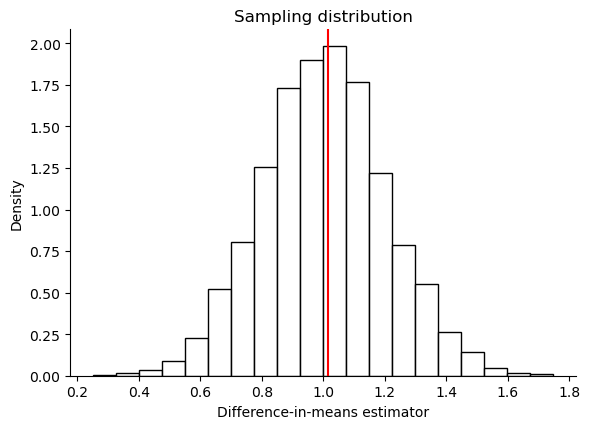

In [7]:
sns.displot(
    diff_means, stat='density', color='white', edgecolor='black',
    height=4, aspect=1.5, bins=20
).set(title='Sampling distribution', xlabel='Difference-in-means estimator')

plt.axvline(SATE, color='red') # true value of SATE

In [8]:
diff_means.std(ddof=1)

0.20121405525623925

In [9]:
np.sqrt(((diff_means - SATE)**2).mean())

0.2015195083097099

In [10]:
# PATE simulation with standard error
sims = 5000
diff_means = np.zeros(sims)
se = np.zeros(sims)

for i in range(sims):
    # generate a sample for each simulation 
    Y0 = stats.norm.rvs(size=n, loc=mu0, scale=sd0)
    Y1 = stats.norm.rvs(size=n, loc=mu1, scale=sd1)
    # randomize treatment by sampling the vector of 0's and 1's created above 
    treat = np.random.choice(sample_vector, size=n, replace=False)
    diff_means[i] = Y1[treat==1].mean() - Y0[treat==0].mean()
    se[i] = (np.sqrt(Y1[treat==1].var(ddof=1) / (n/2) + 
                     Y0[treat==0].var(ddof=1) / (n/2)))
    
diff_means.std(ddof=1)

0.2025428074507152

In [11]:
se.mean()

0.19962151659998345

### Section 7.1.3: Confidence Intervals {-}

**In Progress**